# Examination of the impacts of taking a multi model ensemble mean for MIROC; Feb 2024

In [132]:
%reset -f

In [133]:
# analysis functions
import xarray as xr
import numpy as np

# plotting functions
from matplotlib import pyplot as plt

# systems functions
import os

# my own classes and functions
from GradTrendClasses import Trend, TrendPlotting

## Calculating the MM mean of the gradient (i.e., averaging the time series from the distinct inputs)

In [73]:
trendsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Trends'
gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients'

# run a for loop that concatenates all of the input files along the same new dimension ('gradient') then takes the mean along that dimension
os.chdir(gradientsDir)

# get a list of all of the files in the directory (getting rid of the python checkpoints one)
gradientFiles = os.listdir(gradientsDir)
gradientFiles = [f for f in gradientFiles if '.nc' in f]

# now iterate through the list and concatenate them

# first initialise an xarray file for concatenation
gradientConcat = xr.open_dataset(gradientFiles[0])

for index, file in enumerate(gradientFiles):
    if index > 0:
        modelGradient = xr.open_dataset(file)
        gradientConcat = xr.concat([gradientConcat, modelGradient], dim = 'gradient')

# now calculating the mean along the gradient dimension
gradientMean = gradientConcat.mean(dim = 'gradient')

# cutting this off at for the period that we are interested in
gradientMean = gradientMean.ts.sel(time = slice('1850-01-16T12:00:00.000000000', '2022-12-16T12:00:00.000000000'))

In [117]:
# creating a class version of this so that the Trends class can access it

class CalculateMMEGradient:
    def __init__(self, gradientsDir):
        '''
        Class that takes in the directory of the pre-calcalulated .nc gradient files, concatenates them and calculates the mean gradient across all of them
        
        :param: gradientsDir: directory with gradient files
        
        Outputs: gradientMean: dataarray with the mean gradient calculated, modelName pulled from the file names
        '''
        self.gradientsDir = gradientsDir
        self.gradient = self.ExecuteAllSteps()
        self.modelName = 'MIROC_MME' # THIS IS SPECIFIC TO THIS TRIAL RUN
        
    def CalculateMean(self, gradientsDir):
        # run a for loop that concatenates all of the input files along the same new dimension ('gradient') then takes the mean along that dimension
        os.chdir(gradientsDir)

        # get a list of all of the files in the directory (getting rid of the python checkpoints one)
        gradientFiles = os.listdir(gradientsDir)
        gradientFiles = [f for f in gradientFiles if '.nc' in f]

        # now iterate through the list and concatenate them

        # first initialise an xarray file for concatenation
        gradientConcat = xr.open_dataset(gradientFiles[0])

        for index, file in enumerate(gradientFiles):
            if index > 0:
                modelGradient = xr.open_dataset(file)
                gradientConcat = xr.concat([gradientConcat, modelGradient], dim = 'gradient')

        # now calculating the mean along the gradient dimension
        self.gradientMean = gradientConcat.mean(dim = 'gradient')

        # cutting this off at for the period that we are interested in
        self.gradientMean = self.gradientMean.ts.sel(time = slice('1850-01-16T12:00:00.000000000', '2022-12-16T12:00:00.000000000'))

    def ExecuteAllSteps(self):
        self.CalculateMean(gradientsDir)
        return self.gradientMean

In [118]:
gradientMeanTest = CalculateMMEGradient(gradientsDir)
gradientMeanTest.gradient

<xarray.DataArray 'ts' (time: 2076)>
array([ 0.2610965 ,  0.19709152,  0.20966343, ...,  0.07344978,
       -0.00399859,  0.03251845])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00

## Now running the trend class on it

In [ ]:
# have to create a class so that the output

In [119]:
trends = Trend(gradientMeanTest).trends
trendsDf = Trend(gradientMeanTest).trendsDf

## plotting the trends

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

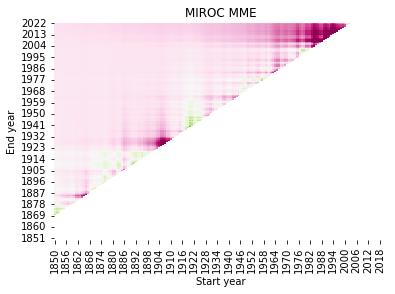

In [131]:
fig = plt.figure()
ax = fig.add_subplot(111)
trendPlotter = TrendPlotting(trendsDf, 'MIROC MME', -0.1, 0.1)
ax = trendPlotter.PlotTrends(ax)

In [72]:
gradientMean.ts.sel(time = slice('1850-01-16T12:00:00.000000000', '2022-12-16T12:00:00.000000000'))

<xarray.DataArray 'ts' (time: 2076)>
array([ 0.2610965 ,  0.19709152,  0.20966343, ...,  0.07344978,
       -0.00399859,  0.03251845])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00

In [14]:
test1 = xr.open_dataset('MIROC6_r10i1p1f1.nc')
test2 = xr.open_dataset('MIROC6_r11i1p1f1.nc')

In [33]:
# combining the two files
combinedTest = xr.concat([test1, test2], dim = 'gradient')
combinedMean = combinedTest.mean(dim = 'gradient')

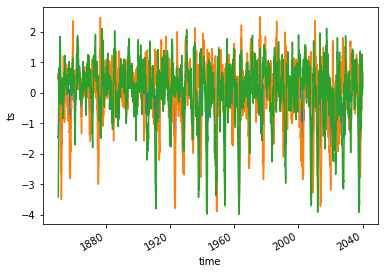

In [39]:
combinedMean.ts.plot()
test1.ts.plot()
test2.ts.plot()

In [41]:
os.listdir(gradientsDir)

['MIROC6_r10i1p1f1.nc',
 'MIROC6_r11i1p1f1.nc',
 'MIROC6_r12i1p1f1.nc',
 'MIROC6_r13i1p1f1.nc',
 'MIROC6_r14i1p1f1.nc',
 'MIROC6_r15i1p1f1.nc',
 'MIROC6_r16i1p1f1.nc',
 'MIROC6_r17i1p1f1.nc',
 'MIROC6_r18i1p1f1.nc',
 'MIROC6_r19i1p1f1.nc',
 'MIROC6_r1i1p1f1.nc',
 'MIROC6_r20i1p1f1.nc',
 'MIROC6_r21i1p1f1.nc',
 'MIROC6_r22i1p1f1.nc',
 'MIROC6_r23i1p1f1.nc',
 'MIROC6_r24i1p1f1.nc',
 'MIROC6_r25i1p1f1.nc',
 'MIROC6_r26i1p1f1.nc',
 'MIROC6_r27i1p1f1.nc',
 'MIROC6_r28i1p1f1.nc',
 'MIROC6_r29i1p1f1.nc',
 'MIROC6_r2i1p1f1.nc',
 'MIROC6_r30i1p1f1.nc',
 'MIROC6_r31i1p1f1.nc',
 'MIROC6_r32i1p1f1.nc',
 'MIROC6_r33i1p1f1.nc',
 'MIROC6_r34i1p1f1.nc',
 'MIROC6_r35i1p1f1.nc',
 'MIROC6_r36i1p1f1.nc',
 'MIROC6_r37i1p1f1.nc',
 'MIROC6_r38i1p1f1.nc',
 'MIROC6_r39i1p1f1.nc',
 'MIROC6_r3i1p1f1.nc',
 'MIROC6_r40i1p1f1.nc',
 'MIROC6_r41i1p1f1.nc',
 'MIROC6_r42i1p1f1.nc',
 'MIROC6_r43i1p1f1.nc',
 'MIROC6_r44i1p1f1.nc',
 'MIROC6_r45i1p1f1.nc',
 'MIROC6_r46i1p1f1.nc',
 'MIROC6_r47i1p1f1.nc',
 'MIROC6_r48i1p1f1.

In [47]:
gradientFiles = os.listdir(gradientsDir)
'MIROC' in gradientFiles[0]

True